In [1]:

import numpy as np 
import pandas as pd 
import os
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split





<h1 style="text-align:center; color:#6A5ACD; font-weight:bold; font-size:38px;">Brain Tumor Classification With Pytorch</h1>


<center> <img src="https://my.clevelandclinic.org/-/scassets/images/org/health/articles/6149-brain-tumor" alt ="Brain Tumor" style='width:50%;'> </center>

# 🧠 Brain Tumor MRI Dataset

### 📖 Overview
This dataset contains MRI scans categorized into four classes: **Glioma**, **Meningioma**, **Pituitary Tumor**, and **No Tumor**. It is designed for researchers and data scientists working on brain tumor classification, medical image analysis, and machine learning model development. The dataset is sourced from [Kaggle](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset) and provides a comprehensive collection of brain MRI images to facilitate the study of brain tumors.

### 📂 Dataset Description
- **Total Images**: Approximately 7,000 MRI scans
- **Classes**: 
  - Glioma
  - Meningioma
  - Pituitary Tumor
  - No Tumor
- **Format**: Images are in `.jpg` format
- **Structure**: The dataset is split into **Training** and **Testing** folders, each containing subfolders for the four classes.
- **Image Size**: Varies, typically 512x512 pixels

### 🧬 About Brain Tumors
Brain tumors are abnormal growths of cells within the brain or its surrounding tissues. They can be benign (non-cancerous) or malignant (cancerous) and are classified based on their origin and behavior. Common types include:

- **Glioma**: Arises from glial cells. It is one of the most common and aggressive types of brain tumors. Gliomas often require rapid intervention due to their infiltrative nature.
- **Meningioma**: Develops from the meninges, the protective layers around the brain and spinal cord. While often benign, they can still cause serious complications depending on their size and location.
- **Pituitary Tumor**: Affects the pituitary gland at the brain's base, influencing hormonal balance and body functions. These are generally benign but can lead to endocrine disorders.
- **No Tumor**: MRI scans showing healthy brains, used as a baseline/control group for classification tasks.

Early detection through imaging techniques like MRI is critical for diagnosis and treatment planning. This dataset aims to support the development of automated classification models to assist radiologists in identifying tumor types accurately.

### 🚀 Potential Applications

- **Brain Tumor Classification**: Developing convolutional neural networks (CNNs) or other deep learning models to classify MRI scans into tumor types or normal cases.
- **Medical Image Segmentation**: Identifying and segmenting tumor regions in MRI scans for precise diagnosis.
- **Transfer Learning**: Utilizing pre-trained models (e.g., ResNet, VGG) for feature extraction and fine-tuning on this dataset.
- **Research and Education**: Supporting academic research and teaching in medical imaging and machine learning.


### 💡 Example Use Case

Train a deep learning model to classify MRI scans into one of the four categories (**Glioma**, **Meningioma**, **Pituitary Tumor**, **No Tumor**). Use image preprocessing techniques such as resizing, normalization, and augmentation (rotation, flipping, zooming) to improve model robustness and performance.

### 🎯 Conclusion

This dataset is a valuable resource for advancing automated brain tumor diagnosis, improving early detection, and fostering innovation in medical imaging technologies. By enabling AI-assisted diagnostics, we can move closer to faster, more accurate, and more accessible healthcare solutions for patients worldwide.



<h1 style="text-align:left; color:#6A5ACD; font-weight:bold; font-size:28px; font-family:Arial, sans-serif;">Import Libraries</h1>

In [2]:
# utils
import os 
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
# torch
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models, datasets

#Remove Warnings
import warnings
warnings.filterwarnings('ignore')

<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#6A5ACD; overflow:hidden"><b>Reading The Data</b></div>

In [3]:
base_directory = '/kaggle/input/brain-tumor-mri-dataset'
train, test = 'Training', 'Testing'
target_size = (224, 224)
random_state = 42
batch_size = 32
num_classes = 4
device = "cuda" if torch.cuda.is_available() else "cpu"
label_map = {
    'notumor': 0,        
    'glioma': 1,         
    'meningioma': 2,     
    'pituitary': 3       
}

In [4]:
categories = os.listdir(base_directory+'/'+train)
print(categories)

['pituitary', 'notumor', 'meningioma', 'glioma']


In [5]:
def display_images(dataset_type, num_images=4, image_size=(224, 224)):
    
    dataset_path = os.path.join(base_directory, dataset_type)

    fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 10))

    for row, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        image_filenames = random.sample(os.listdir(category_path), num_images)  # Select random images
        
        for col, image_filename in enumerate(image_filenames):
            while image_filename == '.DS_Store':
                image_filename = random.sample(os.listdir(category_path), 1)[0]
            image_path = os.path.join(category_path, image_filename)
            image = Image.open(image_path).resize(image_size)
            axes[row, col].imshow(image, cmap='gray')
            axes[row, col].axis('off')
            axes[row, col].set_title(f"{category}")

    plt.tight_layout()
    plt.show()

## Exploring the Data

In [6]:
def plot_class_distribution(dataset_type):
    path = os.path.join(base_directory, dataset_type)
    counts = [len(os.listdir(os.path.join(path, cat))) for cat in categories]

    plt.bar(categories, counts, color = ['navy', 'teal', 'darkorange', 'crimson'])
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"{dataset_type.capitalize()} Set Distribution")
    plt.show()

### Train set

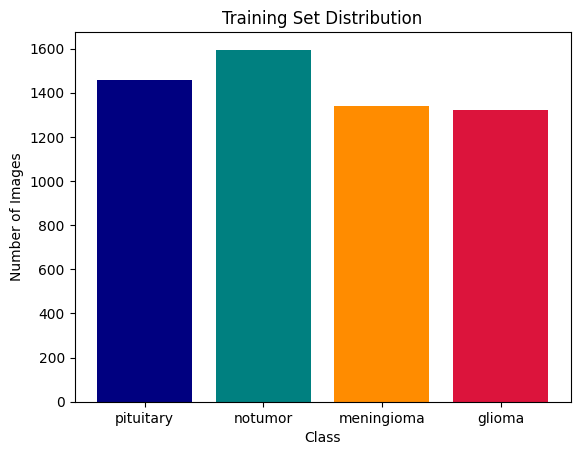

In [7]:
plot_class_distribution(train)

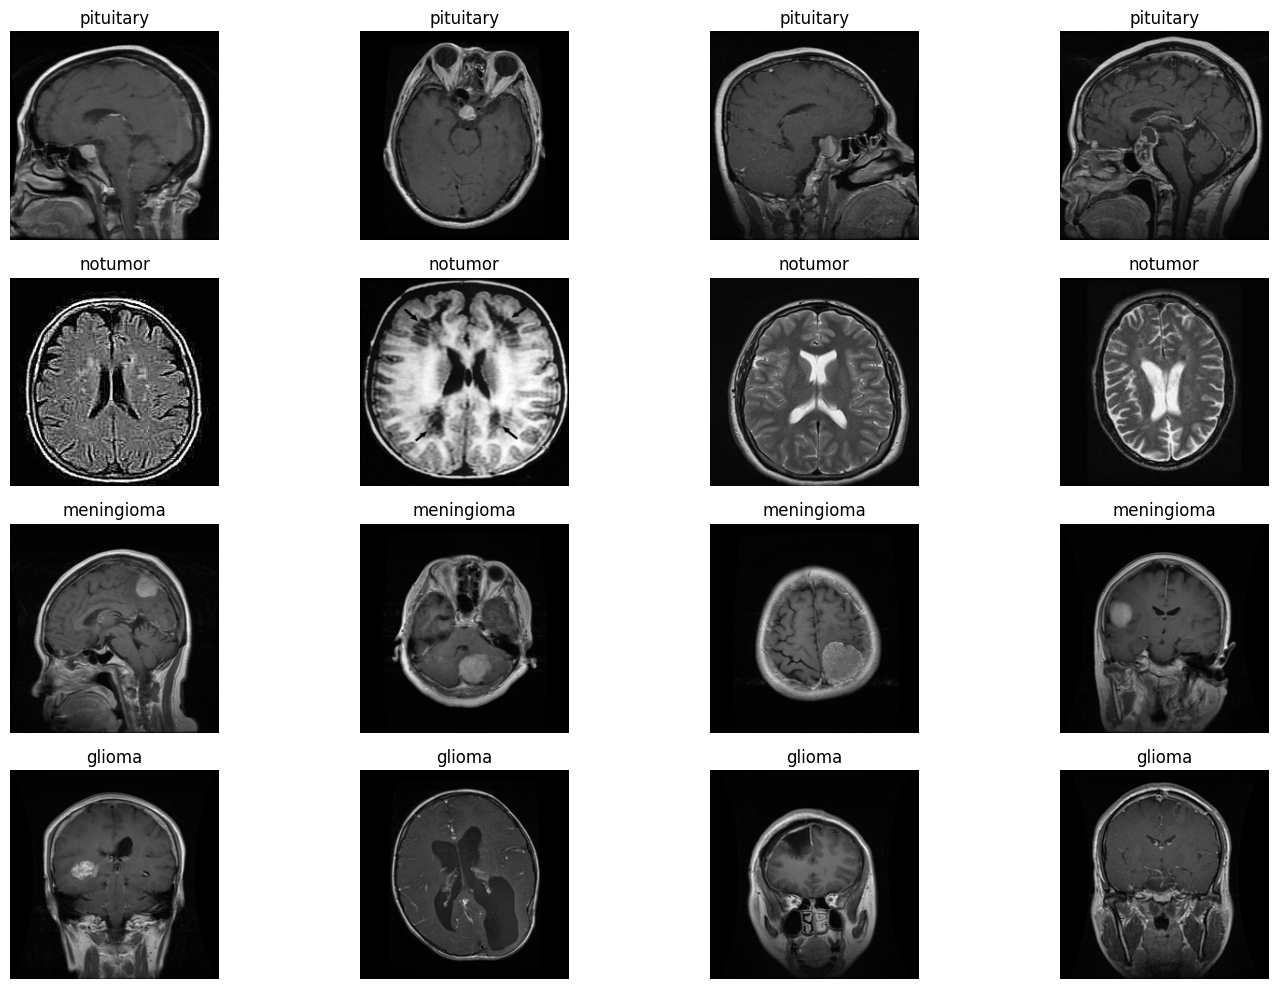

In [8]:
display_images(train)

### Test Set

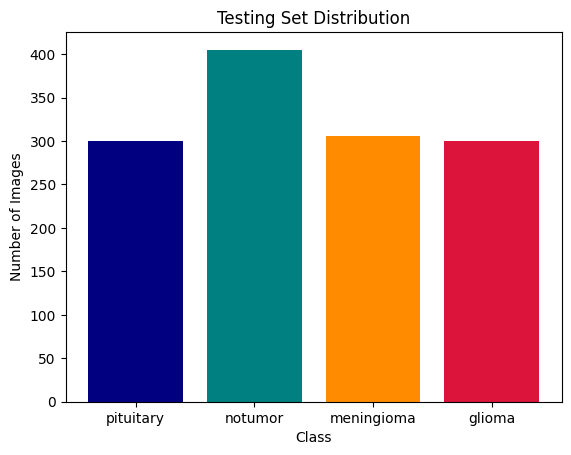

In [9]:
plot_class_distribution(test)

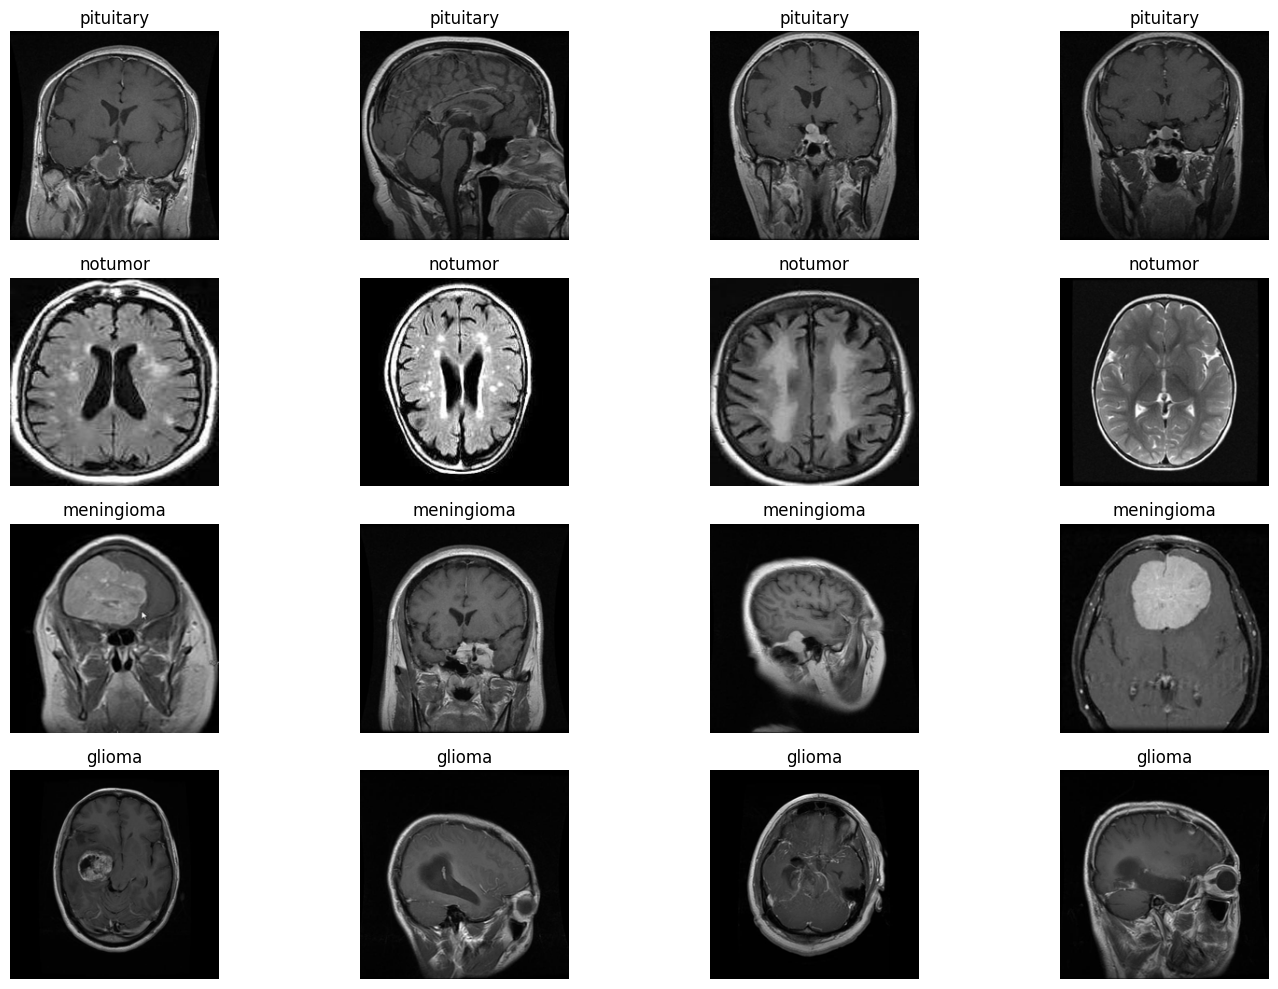

In [10]:
display_images(test)

<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#6A5ACD; overflow:hidden"><b>Preparing the Data</b></div>

In [11]:
def create_dataset(path):
    my_list = []
    for category in categories:
        category_path = os.path.join(path, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            # Ensure we're only adding image files
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                my_list.append([file_path, category])
    return pd.DataFrame(my_list, columns=['file_path', 'label'])

In [12]:
train_df = create_dataset(base_directory+'/'+train)
test_df = create_dataset(base_directory+'/'+test)

In [13]:
train_df['label'] = train_df['label'].map(label_map)
test_df['label'] = test_df['label'].map(label_map)

## Create Class ImageDataset

In [15]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img = Image.open(img_path).convert('RGB')  

        if self.transform:
            img = self.transform(img)
            
        return img, label

## Data Augmentation

In [16]:
train_transform = transforms.Compose([

   transforms.Resize(target_size),
   transforms.RandomHorizontalFlip(),
   transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
   transforms.ColorJitter(brightness=(0.8, 1.2)),
   transforms.RandomRotation(10),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [17]:
test_df_split, val_df_split = train_test_split(test_df, test_size=0.5, random_state=random_state)
# Reset indices for consistency
test_df_split = test_df_split.reset_index(drop=True)
val_df_split = val_df_split.reset_index(drop=True)

In [18]:
train_dataset = ImageDataset(train_df, transform=train_transform)
val_dataset = ImageDataset(val_df_split, transform=test_transform)
test_dataset = ImageDataset(test_df_split, transform=test_transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#6A5ACD; overflow:hidden"><b>Model 1 (Custom CNN)</b></div>

## 🧠 Convolutional Neural Network (CNN) Architecture

The following diagram represents the architecture of our Convolutional Neural Network (CNN) used for **brain tumor classification**.

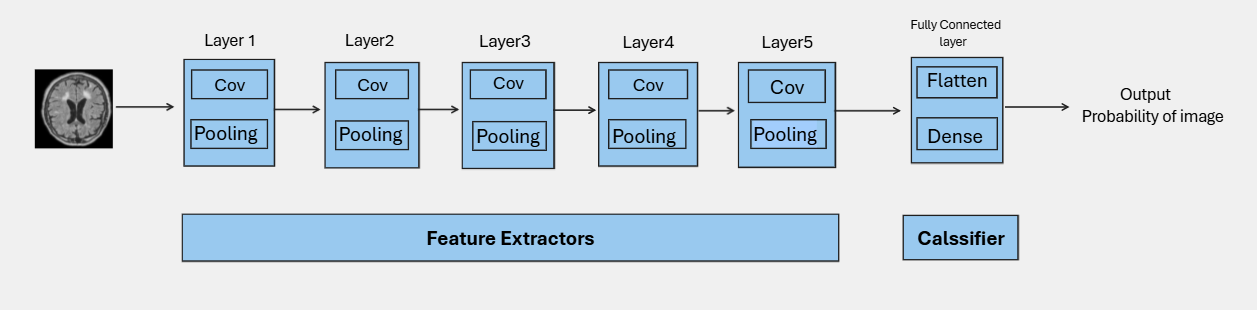


---

### Architecture Breakdown

#### 📥 Input Layer

The input is a brain MRI image (e.g., a scan showing the presence or absence of a tumor) that enters the network.

---

#### 🔍 Feature Extractors

The CNN consists of multiple convolutional layers followed by pooling layers:

- **Layer 1:** Convolution (Conv) + Pooling  
- **Layer 2:** Convolution (Conv) + Pooling  
- **Layer 3:** Convolution (Conv) + Pooling  
- **Layer 4:** Convolution (Conv) + Pooling  
- **Layer 5:** Convolution (Conv) + Pooling  

These layers extract meaningful spatial and texture features from the input image that are important for identifying tumor types.

---

#### 🧠 Classifier

The extracted features are passed through a fully connected (dense) layer:

- **Flatten:** Converts the final feature maps into a 1D array.  
- **Dense:** A fully connected layer to learn high-level representations.  
- **Dropout:** Applied for regularization and to reduce overfitting during training.

---

#### 🎯 Output Layer

A final dense layer provides the probability of the MRI image belonging to one of the predefined tumor classes (e.g., glioma, meningioma, pituitary tumor, or no tumor).

---

This CNN is designed to **efficiently classify brain tumors** by learning deep hierarchical features from MRI scans and making accurate predictions. 🧬📊🧠


In [20]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Conv Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # (B, 32, 224, 224)

        # Conv Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (B, 64, 112, 112)

        # Conv Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # (B, 128, 56, 56)

        # Conv Block 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # (B, 256, 28, 28)

        # Conv Block 5
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # (B, 256, 14, 14)

        # Final shape after pool: (B, 256, 7, 7)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # (B, 32, 112, 112)
        x = self.pool(self.relu(self.conv2(x)))  # (B, 64, 56, 56)
        x = self.pool(self.relu(self.conv3(x)))  # (B, 128, 28, 28)
        x = self.pool(self.relu(self.conv4(x)))  # (B, 256, 14, 14)
        x = self.pool(self.relu(self.conv5(x)))  # (B, 256, 7, 7)

        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [21]:
model = BrainTumorCNN(num_classes=4).to(device) 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

In [22]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, name='model', patience=7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_val_loss = float("inf")
    tolerance = 0  # Counter for early stopping
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
        print("#" * 80)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_brain_tumor_{name}.pth')
            tolerance = 0  
        else:
            tolerance += 1
            if tolerance >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    return history


In [23]:
def test_model(model, test_loader, num_images_to_show=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Collect for later analysis
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu())  # Store images for visualization

    test_acc = 100 * correct / total

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {test_acc:.2f}%\n")
    
    # Print classification report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=categories))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=categories, yticklabels=categories)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [ ]:
print("Starting training...")
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=60)

Starting training...
Epoch [1/60]
Train Loss: 0.9635, Train Accuracy: 58.16%
Val Loss: 0.8663, Val Accuracy: 64.33%
################################################################################
Epoch [2/60]
Train Loss: 0.6693, Train Accuracy: 72.76%
Val Loss: 0.6575, Val Accuracy: 76.07%
################################################################################
Epoch [3/60]
Train Loss: 0.5536, Train Accuracy: 78.33%
Val Loss: 0.5254, Val Accuracy: 78.20%
################################################################################
Epoch [4/60]
Train Loss: 0.4690, Train Accuracy: 82.34%
Val Loss: 0.4652, Val Accuracy: 82.16%
################################################################################
Epoch [5/60]
Train Loss: 0.3731, Train Accuracy: 86.57%
Val Loss: 0.3485, Val Accuracy: 88.26%
################################################################################
Epoch [6/60]
Train Loss: 0.3157, Train Accuracy: 88.22%
Val Loss: 0.3394, Val Accuracy: 85.98%
####

In [ ]:
def plot_training_history(history, model_name="model"):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

In [ ]:
plot_training_history(history, model_name="CustomCNN")

## Evaluation 

In [ ]:
print("\nLoading best model for testing...")
model.load_state_dict(torch.load('best_brain_tumor_model.pth'))
test_model(model, test_loader)

In [ ]:
def visualize_predictions(model, test_loader, num_images=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct_images, incorrect_images = [], []
    correct_labels, incorrect_labels = [], []
    correct_preds, incorrect_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Separate correct and incorrect predictions
            for i in range(len(predicted)):
                if predicted[i] == labels[i]:
                    correct_images.append(images[i])
                    correct_labels.append(labels[i].cpu().item())
                    correct_preds.append(predicted[i].cpu().item())
                else:
                    incorrect_images.append(images[i])
                    incorrect_labels.append(labels[i].cpu().item())
                    incorrect_preds.append(predicted[i].cpu().item())

    # Visualization
    # Unnormalize using your mean and std
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

    num_cols = num_images // 2
    plt.figure(figsize=(15, 7))

    # Display correct predictions
    for i, img_tensor in enumerate(correct_images[:num_images // 2]):
        img_tensor = img_tensor * std + mean  # reverse normalization
        img = np.clip(img_tensor.permute(1, 2, 0).cpu().numpy(), 0, 1)
        plt.subplot(2, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f"True: {categories[correct_labels[i]]}\nPred: {categories[correct_preds[i]]}", color='green', fontsize=15)
        plt.axis('off')

    # Display incorrect predictions
    for i, img_tensor in enumerate(incorrect_images[:num_images // 2]):
        if i >= len(incorrect_images):
            plt.axis('off')
            continue
        img_tensor = img_tensor * std + mean  # reverse normalization
        img = np.clip(img_tensor.permute(1, 2, 0).cpu().numpy(), 0, 1)
        plt.subplot(2, num_cols, num_cols + i + 1)
        plt.imshow(img)
        plt.title(f"True: {categories[incorrect_labels[i]]}\nPred: {categories[incorrect_preds[i]]}", color='red', fontsize=15)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
visualize_predictions(model, test_loader, 8)

In [ ]:
from IPython.display import display

def predict_single_image(image_path, model, transform, label_map):
    # Charger l’image
    image = Image.open(image_path).convert("RGB")
    display(image)

    # Appliquer les transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Ajouter batch dimension

    # Charger le modèle si besoin
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

    # Inverser le label_map
    inv_label_map = {v: k for k, v in label_map.items()}
    predicted_label = inv_label_map[predicted.item()]
    
    print(f"✅ Prédiction : {predicted_label.capitalize()}")

# 🔍 Entrée utilisateur
image_path = input("🔽 Entrez le chemin de votre image : ")
predict_single_image(image_path, model, test_transform, label_map)


## Model Performance and Future Work

The **Custom CNN** model achieved a **satisfactory accuracy of 99.54%**, which is a strong result and indicates good performance on the classification task. However, to further explore the potential for improvement and leverage transfer learning, I would like to experiment with a **pretrained model in PyTorch**.
